In [3]:
!nvidia-smi

Sun Dec 31 20:48:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    On   | 00000000:86:00.0 Off |                  Off |
| 30%   40C    P8    33W / 300W |      5MiB / 49140MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A6000    On   | 00000000:AF:00.0 Off |                  Off |
| 30%   

In [1]:
from ultralytics import YOLO
from bytetracker import BYTETracker
import supervision as sv
from supervision.draw.color import ColorPalette
from supervision import VideoSink, VideoInfo, get_video_frames_generator
from supervision import PolygonZone
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from collections import defaultdict
import torch
from skimage.metrics import structural_similarity as ssim

model = YOLO('./Models/yolov8x.pt')

## Generate frames

In [ ]:
video_info = VideoInfo.from_video_path('./Videos/1.mp4')
frames_generator = get_video_frames_generator('./Videos/1.mp4')

with VideoSink('./Results/1.mp4', video_info) as sink:
    count = 0
    for frame in tqdm(frames_generator, total=video_info.total_frames):
        img_name = f"{count}.png"
        cv2.imwrite(f"./Frames/{img_name}",  frame)
        count = count + 1

## Detect


0: 160x384 1 train, 22.6ms
Speed: 3.2ms preprocess, 22.6ms inference, 1.9ms postprocess per image at shape (1, 3, 160, 384)


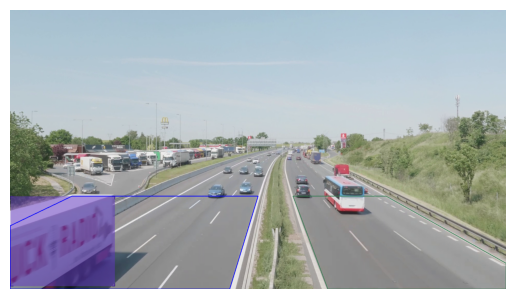

In [2]:
image = cv2.imread('./Frames/46.png')
roi = image[720:1080, 0:960]
result = model.predict(roi, save=False, imgsz=(960,384), show_labels=False, show_conf=False, conf=0.5, verbose=True)[0]
detections = sv.Detections.from_ultralytics(result)

box_corner_annotator = sv.BoxCornerAnnotator(thickness=2, corner_length=10, color=ColorPalette.from_hex(['#2C1C64', '#2C1C64', '#2C1C64']))
color_annotator = sv.ColorAnnotator(ColorPalette.from_hex(['#6336C7', '#6336C7', '#6336C7']))
annotated_frame = box_corner_annotator.annotate(
    scene=roi.copy(),
    detections=detections
)
annotated_frame = color_annotator.annotate(
    scene=annotated_frame.copy(),
    detections=detections
)
image[720:1080, 0:960] = annotated_frame

points = np.array([
    [240, 720],
    [960, 720],
    [850, 1080],
    [0, 1080],
    [0, 835]
])
points_2 = np.array([
    [1095, 720],
    [1455, 720],
    [1920, 980],
    [1920, 1080],
    [1230, 1080]
])
points = points.reshape((-1, 1, 2))
isClosed = True
color = (255, 0, 0)
color_2 = (84, 125, 57)
thickness = 2
annotated_frame = cv2.polylines(image, [points], 
                      isClosed, color, thickness)
annotated_frame = cv2.polylines(annotated_frame, [points_2], 
                      isClosed, color_2, thickness)

# Display the image using matplotlib
plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))  # Use cmap='gray' for grayscale images
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

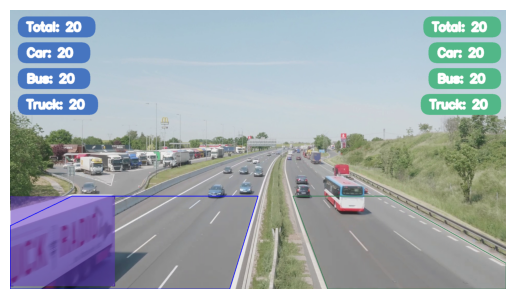

In [8]:
def draw_annotation(image, width, rec_color, text_color, text, corners):
    rectangle_thickness = 2
    corner_radius = 30  

    x, y, height = corners[0], corners[1], 80

    cv2.rectangle(image, (x + corner_radius, y), (x + width - corner_radius, y + height), rectangle_color, -1)
    cv2.rectangle(image, (x, y + corner_radius), (x + width, y + height - corner_radius), rectangle_color, -1)
    cv2.circle(image, (x + corner_radius, y + corner_radius), corner_radius, rectangle_color, -1)
    cv2.circle(image, (x + width - corner_radius, y + corner_radius), corner_radius, rectangle_color, -1)
    cv2.circle(image, (x + corner_radius, y + height - corner_radius), corner_radius, rectangle_color, -1)
    cv2.circle(image, (x + width - corner_radius, y + height - corner_radius), corner_radius, rectangle_color, -1)

    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1.5
    font_thickness = 10
    text_x = x + 35
    text_y = y + 55
    cv2.putText(image, text, (text_x, text_y), font, font_scale, text_color, font_thickness, cv2.LINE_AA)
    return image

y_shift = 100
image = annotated_frame.copy()

org_corners = (30,25)
rectangle_color = (192, 117, 70)
text_color = (255, 255, 255)
width_list = [300, 280, 280, 310] 

txt_list = ["Total: 20", "Car: 20", "Bus: 20", "Truck: 20"]

count = -1
for txt, width in zip(txt_list, width_list):
    count += 1

    corners = org_corners[0], org_corners[1] + y_shift*count
    image = draw_annotation(image, width, rectangle_color, text_color, txt, corners)
  
org_corners = (1620,25)
rectangle_color = (136, 183, 82)
text_color = (255, 255, 255) 
txt_list = ["Total: 20", "Car: 20", "Bus: 20", "Truck: 20"]

count = -1
for txt, width in zip(txt_list, width_list):
    count += 1

    x_align = int(np.array(width_list).min())
    corners = org_corners[0] - (width - x_align), org_corners[1] + y_shift*count
    image = draw_annotation(image, width, rectangle_color, text_color, txt, corners)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Use cmap='gray' for grayscale annotated_frames
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()


## Tracking

In [5]:
from bytetracker import BYTETracker
import torch

tracker = BYTETracker()

In [139]:
def unused_class_masking(detections, cls_list):
    id_list = []
    count = 0
    for det in detections:
        if det[3] in cls_list:
            id_list.append(count)
        count += 1
    xyxy = np.zeros((len(id_list), 4)).astype('float32')
    conf = []
    cls_id = []
    for id in id_list:
        xyxy[id,:] = detections.xyxy[id,:]
        conf.append(detections.confidence[id])
        cls_id.append(detections.class_id[id])
    detections.xyxy = xyxy
    detections.confidence = np.array(conf).astype('float32')
    detections.class_id = np.array(cls_id).astype('int64')
    return detections

In [166]:
cls_list = [1,2,3,5,7]

detections = unused_class_masking(detections, cls_list)

dets = torch.tensor(np.hstack((
    detections.xyxy,
    detections.confidence[:, np.newaxis],
    detections.class_id[:, np.newaxis]
)))

tracks = tracker.update(dets, None)
track_ids = tracks[:,4].astype('int64')
track_cls = tracks[:,5].astype('int64')

detections.tracker_id = track_ids

detections

Detections(xyxy=array([[     470.97,      133.24,      647.88,      292.81],
       [     796.66,      52.534,      893.65,      148.26],
       [     408.06,       58.77,      552.46,      169.88]], dtype=float32), mask=None, confidence=array([    0.90667,     0.90019,      0.8979], dtype=float32), class_id=array([2, 2, 2]), tracker_id=array([2, 3, 1]))

## Trigger frame

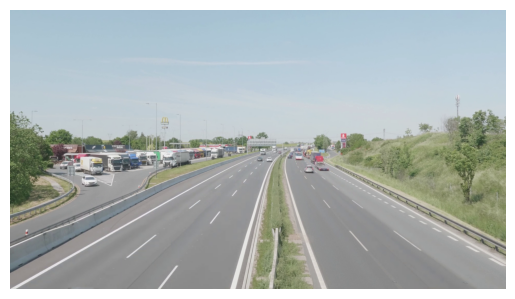

In [2]:
#130, 100
id = 255
image = cv2.imread(f'./Frames/{id}.png')

points = np.array([
    [240, 720],
    [960, 720],
    [850, 1080],
    [0, 1080],
    [0, 835]
])
points_2 = np.array([
    [1095, 720],
    [1455, 720],
    [1920, 980],
    [1920, 1080],
    [1230, 1080]
])
points = points.reshape((-1, 1, 2))
points_2 = points_2.reshape((-1, 1, 2))
isClosed = True
# Blue color in BGR
color = (255, 0, 0)
# Line thickness of 2 px
thickness = 2
# Using cv2.polylines() method
# Draw a Blue polygon with 
# thickness of 1 px
# image = cv2.polylines(image, [points], 
#                       isClosed, color, thickness)
# image = cv2.polylines(image, [points_2], 
#                       isClosed, color, thickness)


# Display the image using matplotlib
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Use cmap='gray' for grayscale images
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

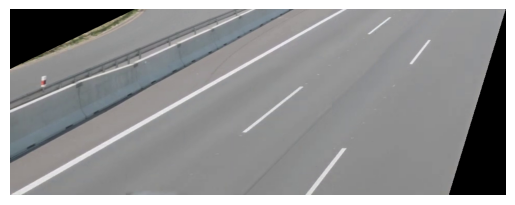

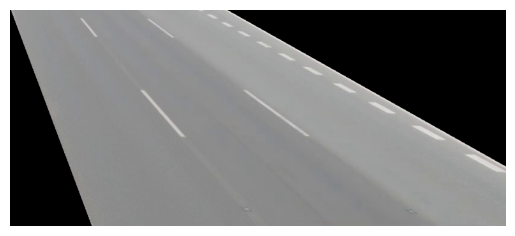

True

In [11]:
def mask_crop_trigger_zone(image, zone, direction):
    cropped_image = None

    if direction == 'out':
        cropped_image = image[zone[0][1]:zone[2][1], zone[4][0]:zone[1][0]]
        left_black_area = np.array([
            [0, 0],
            [zone[0][0] - zone[3][0], 0],
            [0, zone[4][1] - zone[0][1]]
        ], dtype=np.int32)
        right_black_area = np.array([
            [zone[1][0] - zone[3][0], 0],
            [zone[1][0] - zone[3][0], zone[2][1] - zone[1][1]],
            [zone[2][0] - zone[3][0], zone[2][1] - zone[1][1]]
        ], dtype=np.int32)
    else:
        cropped_image = image[zone[0][1]:zone[3][1], zone[0][0]:zone[3][0]]
        left_black_area = np.array([
            [0, 0],
            [0, zone[4][1] - zone[0][1]],
            [zone[4][0] - zone[0][0], zone[4][1] - zone[0][1]]
        ], dtype=np.int32)
        right_black_area = np.array([
            [zone[1][0] - zone[0][0], 0],
            [zone[2][0] - zone[0][0], 0],
            [zone[2][0] - zone[0][0], zone[2][1] - zone[1][1]]
        ], dtype=np.int32)

    masked_crop_image = cropped_image.copy()
    cv2.fillPoly(masked_crop_image, [left_black_area], (0, 0, 0))
    cv2.fillPoly(masked_crop_image, [right_black_area], (0, 0, 0))

    return masked_crop_image

left_points = np.array([
    [240, 720],
    [960, 720],
    [850, 1080],
    [0, 1080],
    [0, 835]
])
masked_left_cropped_image = mask_crop_trigger_zone(image, left_points, 'out')
plt.imshow(cv2.cvtColor(masked_left_cropped_image, cv2.COLOR_BGR2RGB))  # Use cmap='gray' for grayscale images
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()
cv2.imwrite("./Data/masked_left_zone.png", masked_left_cropped_image)
right_points = np.array([
    [1095, 720],
    [1455, 720],
    [1920, 980],
    [1920, 1080],
    [1230, 1080]
])
masked_right_cropped_image = mask_crop_trigger_zone(image, right_points, 'in')
plt.imshow(cv2.cvtColor(masked_right_cropped_image, cv2.COLOR_BGR2RGB))  # Use cmap='gray' for grayscale images
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()
cv2.imwrite("./Data/masked_right_zone.png", masked_right_cropped_image)

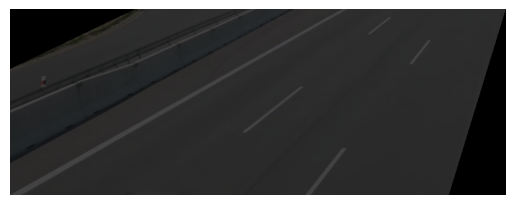

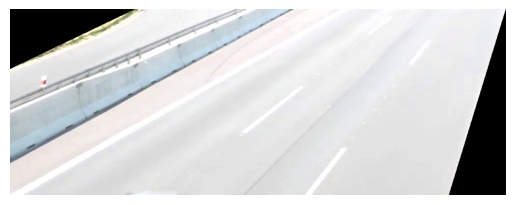

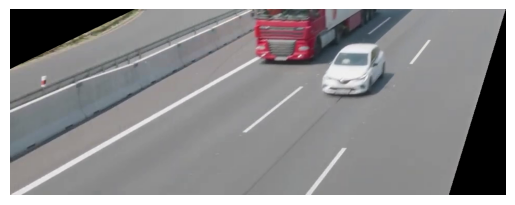

True

In [104]:
intensity_factor = 0.3  # intensity level
darker_image = np.clip(masked_left_cropped_image * intensity_factor, 0, 255)
darker_image = np.uint8(darker_image)

# noise = np.random.randint(-30, 30, darker_image.shape, dtype=np.int8)
# darker_image = cv2.add(darker_image, noise, dtype=cv2.CV_8U)

plt.imshow(cv2.cvtColor(darker_image, cv2.COLOR_BGR2RGB))  # Use cmap='gray' for grayscale images
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()
cv2.imwrite("./Data/dark_left_zone.jpg", darker_image)

intensity_factor = 1.6  # intensity level
brighter_image = np.clip(masked_left_cropped_image * intensity_factor, 0, 255)
brighter_image = np.uint8(brighter_image)

# noise = np.random.randint(-30, 30, darker_image.shape, dtype=np.int8)
# darker_image = cv2.add(darker_image, noise, dtype=cv2.CV_8U)

plt.imshow(cv2.cvtColor(brighter_image, cv2.COLOR_BGR2RGB))  # Use cmap='gray' for grayscale images
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()
cv2.imwrite("./Data/bright_left_zone.jpg", brighter_image)

car_filled_image = cv2.imread('./Frames/12.png')
left_points = np.array([
    [240, 720],
    [960, 720],
    [850, 1080],
    [0, 1080],
    [0, 835]
])
masked_car_image = mask_crop_trigger_zone(car_filled_image, left_points, 'out')
plt.imshow(cv2.cvtColor(masked_car_image, cv2.COLOR_BGR2RGB))  # Use cmap='gray' for grayscale images
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()
cv2.imwrite("./Data/masked_car_filled_zone.png", masked_car_image)

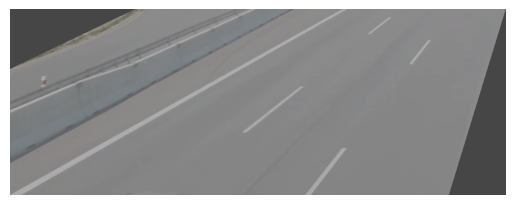

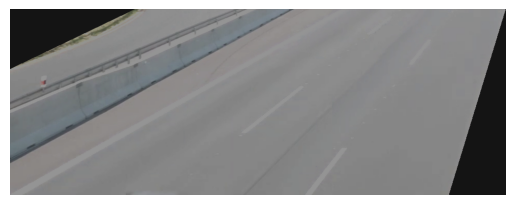

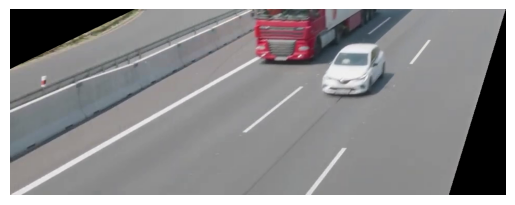

In [121]:
def auto_adjust_brightness(image):
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    dark_pixels = np.sum(hist[:50]) / np.sum(hist)
    bright_pixels = np.sum(hist[205:]) / np.sum(hist)
    dark_threshold = 0.6
    bright_threshold = 0.6
    # mean_val = np.mean(image)
    alpha, beta = None, None
    if dark_pixels > dark_threshold:
        alpha = 1.5
        beta = 70
    elif bright_pixels > bright_threshold:
        alpha = 0.5
        beta = 20
    adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

    return adjusted

adjusted_dark = auto_adjust_brightness(darker_image)
plt.imshow(cv2.cvtColor(adjusted_dark, cv2.COLOR_BGR2RGB))  # Use cmap='gray' for grayscale images
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()
adjusted_bright = auto_adjust_brightness(brighter_image)
plt.imshow(cv2.cvtColor(adjusted_bright, cv2.COLOR_BGR2RGB))  # Use cmap='gray' for grayscale images
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()
adjusted_car = auto_adjust_brightness(masked_car_image)
plt.imshow(cv2.cvtColor(adjusted_car, cv2.COLOR_BGR2RGB))  # Use cmap='gray' for grayscale images
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

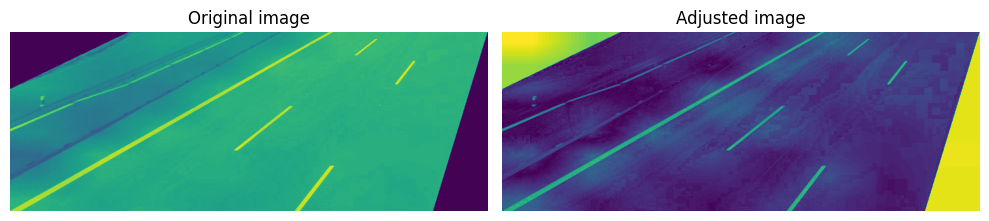

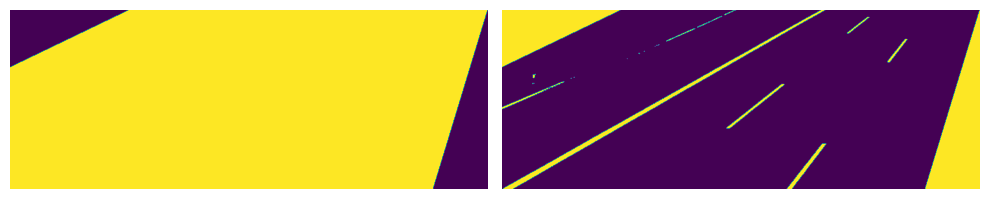

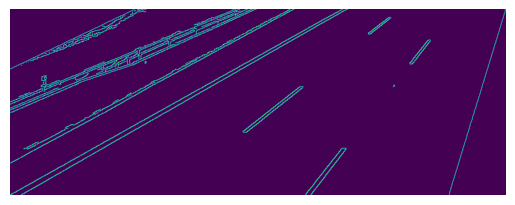

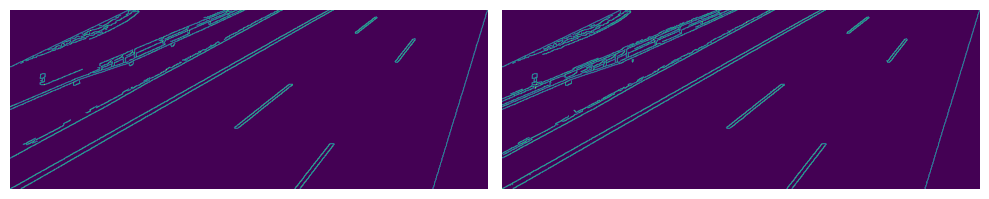

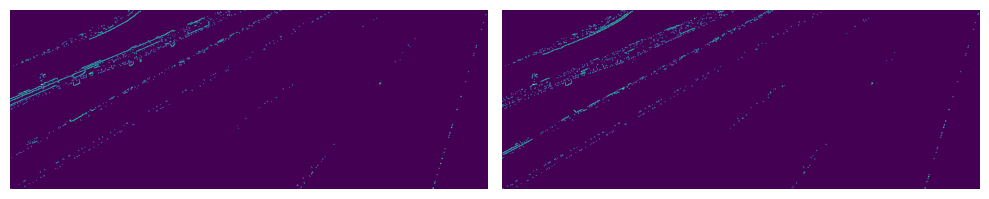

SSIM: 0.9662659978696064 - 0.9704264528685665


In [102]:
gray1 = cv2.cvtColor(masked_left_cropped_image, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(darker_image, cv2.COLOR_BGR2GRAY)
gray3 = cv2.cvtColor(adjusted_dark, cv2.COLOR_BGR2GRAY)

# gray2 = cv2.medianBlur(gray2, 7)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
gray2 = clahe.apply(gray2)
gray3 = clahe.apply(gray3)

difference = cv2.absdiff(gray1, gray2)
difference_2 = cv2.absdiff(gray1, gray3)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(difference)
axes[0].set_title('Original image')
axes[0].axis('off')
axes[1].imshow(difference_2)
axes[1].set_title('Adjusted image')
axes[1].axis('off')
plt.tight_layout()
plt.show()

_, thresh = cv2.threshold(difference, 30, 255, cv2.THRESH_BINARY)
_, thresh_2 = cv2.threshold(difference_2, 30, 255, cv2.THRESH_BINARY)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(thresh)
axes[0].axis('off')
axes[1].imshow(thresh_2)
axes[1].axis('off')
plt.tight_layout()
plt.show()

edges1 = cv2.Canny(gray1, 50, 150)
edges2 = cv2.Canny(gray2, 50, 150)
edges3 = cv2.Canny(gray3, 50, 150)

plt.imshow(edges1)  # Use cmap='gray' for grayscale images
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(edges2)
axes[0].axis('off')
axes[1].imshow(edges3)
axes[1].axis('off')
plt.tight_layout()
plt.show()

difference = cv2.absdiff(edges1, edges2)
difference_2 = cv2.absdiff(edges1, edges3)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(difference)
axes[0].axis('off')
axes[1].imshow(difference_2)
axes[1].axis('off')
plt.tight_layout()
plt.show()

(score, diff), (score2, diff2) = ssim(edges1, edges2, full=True), ssim(edges1, edges3, full=True)
print(f"SSIM: {score} - {score2}")

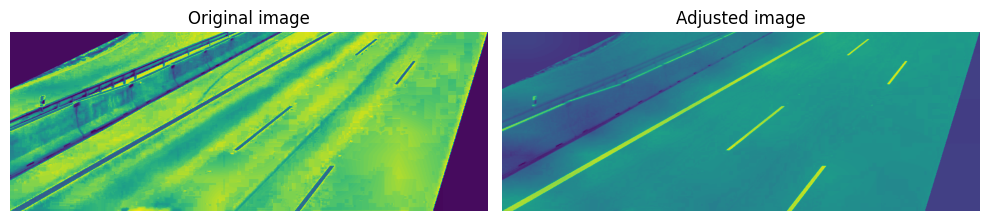

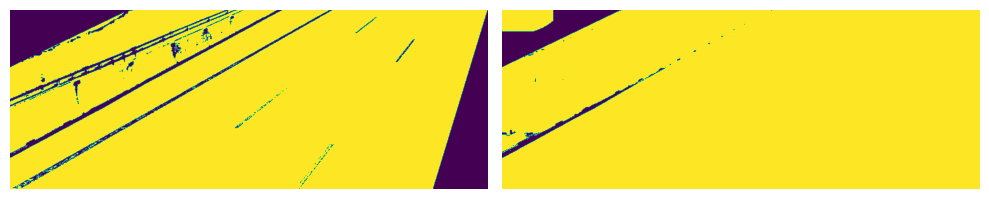

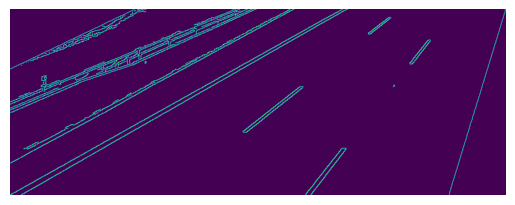

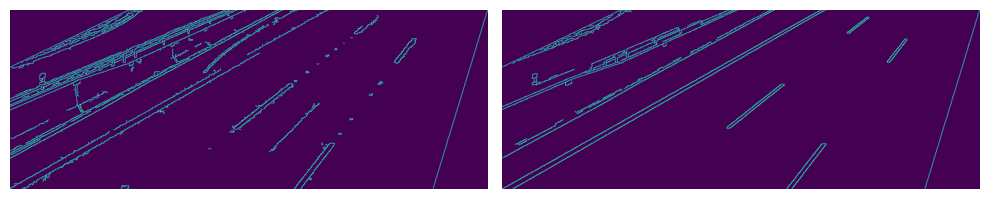

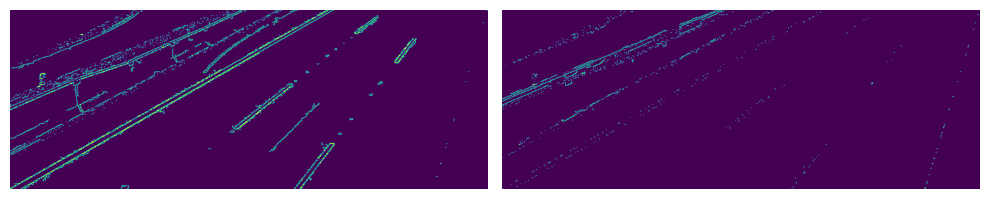

SSIM: 0.8612985904594739 - 0.9657038765737909


In [103]:
gray1 = cv2.cvtColor(masked_left_cropped_image, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(brighter_image, cv2.COLOR_BGR2GRAY)
gray3 = cv2.cvtColor(adjusted_bright, cv2.COLOR_BGR2GRAY)

# gray2 = cv2.medianBlur(gray2, 7)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
gray2 = clahe.apply(gray2)
gray3 = clahe.apply(gray3)

difference = cv2.absdiff(gray1, gray2)
difference_2 = cv2.absdiff(gray1, gray3)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(difference)
axes[0].set_title('Original image')
axes[0].axis('off')
axes[1].imshow(difference_2)
axes[1].set_title('Adjusted image')
axes[1].axis('off')
plt.tight_layout()
plt.show()

_, thresh = cv2.threshold(difference, 30, 255, cv2.THRESH_BINARY)
_, thresh_2 = cv2.threshold(difference_2, 30, 255, cv2.THRESH_BINARY)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(thresh)
axes[0].axis('off')
axes[1].imshow(thresh_2)
axes[1].axis('off')
plt.tight_layout()
plt.show()

edges1 = cv2.Canny(gray1, 50, 150)
edges2 = cv2.Canny(gray2, 50, 150)
edges3 = cv2.Canny(gray3, 50, 150)

plt.imshow(edges1)  # Use cmap='gray' for grayscale images
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(edges2)
axes[0].axis('off')
axes[1].imshow(edges3)
axes[1].axis('off')
plt.tight_layout()
plt.show()

difference = cv2.absdiff(edges1, edges2)
difference_2 = cv2.absdiff(edges1, edges3)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(difference)
axes[0].axis('off')
axes[1].imshow(difference_2)
axes[1].axis('off')
plt.tight_layout()
plt.show()

(score, diff), (score2, diff2) = ssim(edges1, edges2, full=True), ssim(edges1, edges3, full=True)
print(f"SSIM: {score} - {score2}")

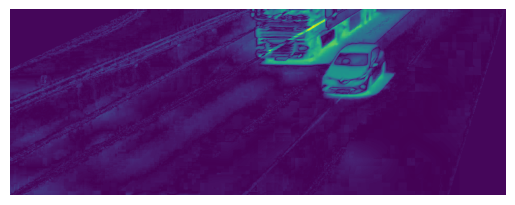

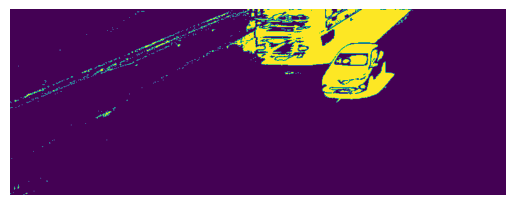

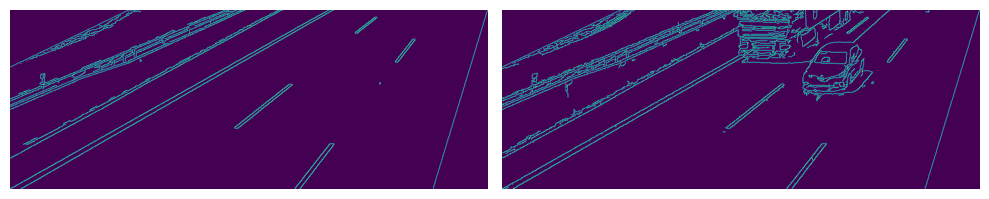

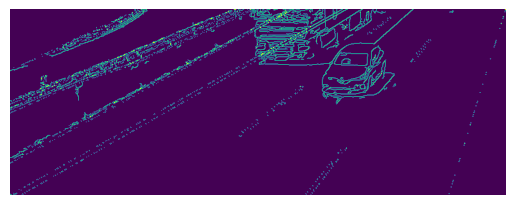

SSIM: 0.8581614360653846


In [122]:
gray1 = cv2.cvtColor(masked_left_cropped_image, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(masked_car_image, cv2.COLOR_BGR2GRAY)

# gray2 = cv2.medianBlur(gray2, 7)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
gray2 = clahe.apply(gray2)
difference = cv2.absdiff(gray1, gray2)
plt.imshow(difference)
plt.axis('off')
plt.show()

_, thresh = cv2.threshold(difference, 30, 255, cv2.THRESH_BINARY)
plt.imshow(thresh)
plt.axis('off')
plt.show()

edges1 = cv2.Canny(gray1, 50, 150)
edges2 = cv2.Canny(gray2, 50, 150)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(edges1)
axes[0].axis('off')
axes[1].imshow(edges2)
axes[1].axis('off')
plt.tight_layout()
plt.show()

difference = cv2.absdiff(edges1, edges2)
plt.imshow(difference)
plt.axis('off')
plt.show()

(score, diff) = ssim(edges1, edges2, full=True)
print(f"SSIM: {score}")

## Full progress

In [3]:
def unused_class_masking(detections, cls_list):
    if detections.class_id.shape[0] == 0:
        return detections

    id_list = []
    count = 0
    for det in detections:
        if det[3] in cls_list:
            id_list.append(count)
        count += 1

    xyxy = np.zeros((len(id_list), 4)).astype('float32')
    conf = []
    cls_id = []
    for i, id in enumerate(id_list):
        xyxy[i,:] = detections.xyxy[id,:]
        conf.append(detections.confidence[id])
        cls_id.append(detections.class_id[id])
    detections.xyxy = xyxy
    detections.confidence = np.array(conf).astype('float32')
    detections.class_id = np.array(cls_id).astype('int64')
    return detections

def synchronize_id_order(det_xyxy, track_xyxy, track_ids, track_xyxy_history):
    track_ids_order = []
    for track_id, track_box in zip(track_ids, track_xyxy):
        prev_track_xyxy = [det_box if len(track_xyxy_history[track_id]) == 0 else track_xyxy_history[track_id] for det_box in det_xyxy]
        
        # Calculate the similarities of each detected candidate with the current tracked object and the pevious tracked object
        distances = [np.linalg.norm(track_box - det_box) + np.linalg.norm(prev_track_xyxy - det_box) for det_box, prev_track_box in zip(det_xyxy, prev_track_xyxy)]
        
        # Get the box info of the detected candidate which is most similar to the tracked object 
        # and the previous track result of corresponding object 
        sorted_indices = np.argsort(distances)
        for idx in sorted_indices:
            if idx in track_ids_order:
                continue
            closest_box_index = idx
            break
        track_ids_order.append(closest_box_index)
    track_ids_order_arr = np.array(track_ids_order)
    track_xyxy = det_xyxy[track_ids_order_arr]
    return track_xyxy

def draw_tracking_path(frame, track_xyxy, track_ids, track_history, color, direction, track_xyxy_history):
    h, w = frame.shape[0], frame.shape[1]
    for box, track_id in zip(track_xyxy, track_ids):
        # Store previous box info for later proximity calculation
        track_xyxy_history[track_id] = box

        track = track_history[track_id]
        
        validate = False
        if direction == 'in':
            x, y = (box[0] + box[2]) / 2.0,  (box[1] + box[3]) / 2.0
            prev_y = track[-1][1] if (len(track) > 0) else h
            if int(y) > int(h) - 40 or int(y) < 5:
                if int(y - prev_y) < -1:
                    validate = True
            else:
                validate = True
        else:
            x, y = box[0] + (box[2] - box[0]) / 3.0,  box[3]
            prev_y = track[-1][1] if (len(track) > 0) else 0
            if int(x) < 25 or  int(y) < 5:
                if int(y - prev_y) > 2:
                    validate = True
            elif int(y) < int(h) - 15:
                validate = True

        if validate:
            track.append((float(x), float(y)))

        if len(track) > 0:
            track_points = np.hstack(track).astype('int32').reshape((-1, 1, 2))
            cv2.polylines(frame, [track_points], isClosed=False, color=color, thickness=3)

        # print(float(x), float(y), box)
        # frame = cv2.circle(frame, (int(a), int(b)), 10, (142, 24, 255), -1) 

        if len(track) > 30:
            track.pop(0)
            
    return frame

def count_vehicle(track_xyxy, track_ids, count_line, direction, track_cls, track_list, count_list):
    for track_id, box, cls in zip(track_ids, track_xyxy, track_cls):
        x1, y1, x2, y2 = box
        anchors = [
            (x1, y1),
            (x1, y2),
            (x2, y1),
            (x2, y2)
        ]

        # Chekc if the entire bounding box is in the zone
        valid_triggers = []
        start_point, end_point = count_line[0], count_line[1]
        line_vec = ((end_point[0] - start_point[0]), (end_point[1] - start_point[1]))
        for point in anchors:
            anchor_vec = ((point[0] - start_point[0]), (point[1] - start_point[1]))
            cross_product = line_vec[0]*anchor_vec[1] - line_vec[1]*anchor_vec[0]
            
            if direction == 'in':
                if cross_product < 0:
                    valid_triggers.append(True)
                else:
                    valid_triggers.append(False)
            else:
                if cross_product > 0:
                    valid_triggers.append(True)
                else:
                    valid_triggers.append(False)
        if len(set(valid_triggers)) == 2:
            continue

        # Check if the tracked object in the list before
        if track_id not in track_list and valid_triggers[0] == False:
            track_list[track_id] = valid_triggers[0]
            continue
            
        # State remains unchanged
        if track_list[track_id] == valid_triggers[0]:
            continue

        track_list[track_id] = valid_triggers[0]
        if cls == 1: # bicycle
            count_list[0] = count_list[0] + 1
        elif cls == 2: # car
            count_list[1] = count_list[1] + 1
        elif cls == 3: # motorcycle
            count_list[2] = count_list[2] + 1
        elif cls == 5: # bus
            count_list[3] = count_list[3] + 1
        elif cls == 7: # truck
            count_list[4] = count_list[4] + 1

    return count_list

def draw_annotation(image, width, rec_color, text_color, text, corners):
    x, y, height = corners[0], corners[1], 80
    corner_radius = 30

    # Draw rounded-cornder rectangle
    cv2.rectangle(image, (x + corner_radius, y), (x + width - corner_radius, y + height), rectangle_color, -1)
    cv2.rectangle(image, (x, y + corner_radius), (x + width, y + height - corner_radius), rectangle_color, -1)
    cv2.circle(image, (x + corner_radius, y + corner_radius), corner_radius, rectangle_color, -1)
    cv2.circle(image, (x + width - corner_radius, y + corner_radius), corner_radius, rectangle_color, -1)
    cv2.circle(image, (x + corner_radius, y + height - corner_radius), corner_radius, rectangle_color, -1)
    cv2.circle(image, (x + width - corner_radius, y + height - corner_radius), corner_radius, rectangle_color, -1)

    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1.5
    font_thickness = 10
    # text_size = cv2.getTextSize(text, font, font_scale, font_thickness)[0]
    text_x = x + 35
    text_y = y + 55
    cv2.putText(image, text, (text_x, text_y), font, font_scale, text_color, font_thickness, cv2.LINE_AA)
    
    return image

def mask_crop_trigger_zone(image, zone, direction):
    cropped_image = None

    if direction == 'out':
        cropped_image = image[zone[0,0][1]:zone[2,0][1], zone[4,0][0]:zone[1,0][0]]
        left_black_area = np.array([
            [0, 0],
            [zone[0,0][0] - zone[3,0][0], 0],
            [0, zone[4,0][1] - zone[0,0][1]]
        ], dtype=np.int32)
        right_black_area = np.array([
            [zone[1,0][0] - zone[3,0][0], 0],
            [zone[1,0][0] - zone[3,0][0], zone[2,0][1] - zone[1,0][1]],
            [zone[2,0][0] - zone[3,0][0], zone[2,0][1] - zone[1,0][1]]
        ], dtype=np.int32)
    else:
        cropped_image = image[zone[0,0][1]:zone[3,0][1], zone[0,0][0]:zone[3,0][0]]
        left_black_area = np.array([
            [0, 0],
            [0, zone[4,0][1] - zone[0,0][1]],
            [zone[4,0][0] - zone[0,0][0], zone[4,0][1] - zone[0,0][1]]
        ], dtype=np.int32)
        right_black_area = np.array([
            [zone[1,0][0] - zone[0,0][0], 0],
            [zone[2,0][0] - zone[0,0][0], 0],
            [zone[2,0][0] - zone[0,0][0], zone[2,0][1] - zone[1,0][1]]
        ], dtype=np.int32)

    masked_crop_image = cropped_image.copy()
    cv2.fillPoly(masked_crop_image, [left_black_area], (0, 0, 0))
    cv2.fillPoly(masked_crop_image, [right_black_area], (0, 0, 0))

    return masked_crop_image

def auto_adjust_brightness(image):
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    dark_pixels = np.sum(hist[:50]) / np.sum(hist)
    bright_pixels = np.sum(hist[205:]) / np.sum(hist)
    dark_threshold = 0.6
    bright_threshold = 0.6
    # mean_val = np.mean(image)
    alpha, beta = None, None
    if dark_pixels > dark_threshold:
        alpha = 1.5
        beta = 70
    elif bright_pixels > bright_threshold:
        alpha = 0.5
        beta = 20
    adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

    return adjusted

def trigger_detect(image, zone, direction):
    background = None
    if direction == 'in':
        background = cv2.imread('./Data/masked_right_zone.png')
    else:
        background = cv2.imread('./Data/masked_left_zone.png')

    adjusted_image = auto_adjust_brightness(image)
    checked_zone = mask_crop_trigger_zone(adjusted_image, zone, direction)

    gray1 = cv2.cvtColor(background, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(checked_zone, cv2.COLOR_BGR2GRAY)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray2 = clahe.apply(gray2)

    edges1 = cv2.Canny(gray1, 50, 150)
    edges2 = cv2.Canny(gray2, 50, 150)

    (score, diff) = ssim(edges1, edges2, full=True)

    if direction == 'in':
        if score < 0.985:
            return True
        else:
            return False
    else:
        if score < 0.93:
            return True
        else:
            return False


vid_id = 3
video_info = VideoInfo.from_video_path(f'./Videos/{vid_id}.mp4')
frames_generator = get_video_frames_generator(f'./Videos/{vid_id}.mp4')

tracker = BYTETracker()
tracker_2 = BYTETracker()

points = np.array([
    [240, 720],
    [960, 720],
    [850, 1080],
    [0, 1080],
    [0, 835]
])
points_2 = np.array([
    [1095, 720],
    [1455, 720],
    [1920, 980],
    [1920, 1080],
    [1230, 1080]
])
points = points.reshape((-1, 1, 2))
points_2 = points_2.reshape((-1, 1, 2))
isClosed = True
color = (255, 0, 0)
color_2 = (84, 125, 57)
zone_thickness = 2
history = defaultdict(lambda: [])
history_2 = defaultdict(lambda: [])
track_xyxy_history = defaultdict(lambda: [])
cls_list = [1,2,3,5,7]

trackers = [tracker, tracker_2]
color_box_corners = [ColorPalette.from_hex(['#2C1C64', '#2C1C64', '#2C1C64']), ColorPalette.from_hex(['#397d54', '#397d54', '#397d54'])]
color_box_backgrounds = [ColorPalette.from_hex(['#6336C7', '#6336C7', '#6336C7']), ColorPalette.from_hex(['#73c088', '#73c088', '#73c088'])]
color_zones = [color, color_2]
zones = [points, points_2]
track_histories = [history, history_2]
directions = ['out', 'in']

in_out_count_list = np.zeros((2,5)).astype('int32')
track_list = defaultdict(lambda: [])
start_lines = [(240,0+10), (135,360-10)]
end_lines = [(960,0+10), (825,360-10)]

org_corners, rectangle_color, txt_list = None, None, None
total, bicy, car, moto, bus, truck = int(0), int(0), int(0), int(0), int(0), int(0)

with VideoSink(f'./Results/{vid_id}.mp4', video_info) as sink:
    for frame in tqdm(frames_generator, total=video_info.total_frames):

        for tracker, color_box_corner, color_box_background, color_zone, zone, track_history, direction, count_list, start_line, end_line in zip(trackers, color_box_corners, color_box_backgrounds, color_zones, zones, track_histories, directions, in_out_count_list, start_lines, end_lines):
            roi, img_sz_detect = None, None
            if direction == 'out':
                roi = frame[720:1080, 0:960]
                img_sz_detect = (960, 384)
            else:
                roi = frame[720:1080, 1095:1920]
                img_sz_detect = (832, 384)

            # Wait for trigger object to perform the end-to-end counting progress
            if trigger_detect(frame, zone, direction):
                result = model.predict(source=roi, save=False, imgsz=img_sz_detect, show_labels=False, show_conf=False, conf=0.35, verbose=False)[0]
                detections = sv.Detections.from_ultralytics(result)
                detections = unused_class_masking(detections, cls_list)

                # Perform tracking only when there are detected objects
                num_dets = detections.class_id.shape[0]
                if num_dets > 0:
                    dets = torch.tensor(np.hstack((
                        detections.xyxy,
                        detections.confidence[:, np.newaxis],
                        detections.class_id[:, np.newaxis]
                    )))

                    # Perform counting vehicles only when there are tracked objects
                    tracks = tracker.update(dets, None)
                    num_tracks = tracks.shape[0]
                    if num_tracks > 0:
                        track_xyxy = tracks[:,:4].astype('float64')
                        track_ids = tracks[:,4].astype('int64')
                        track_cls = tracks[:,5].astype('int64')

                        # Synchronize the order of detection results and tracking results
                        track_xyxy = synchronize_id_order(detections.xyxy, track_xyxy, track_ids, track_xyxy_history)

                        # Count vehicles
                        count_line = (start_line, end_line)
                        count_list = count_vehicle(track_xyxy, track_ids, count_line, direction, track_cls, track_list, count_list)

                        # Draw path of each tracked vehicle
                        roi = draw_tracking_path(roi, track_xyxy, track_ids, track_history, color_zone, direction, track_xyxy_history)

                    # Draw annotation for detected vehicles
                    box_corner_annotator = sv.BoxCornerAnnotator(thickness=2, corner_length=15, color=color_box_corner)
                    color_annotator = sv.ColorAnnotator(color_box_background)
                    annotated_frame = box_corner_annotator.annotate(
                        scene=roi.copy(),
                        detections=detections
                    )
                    annotated_frame = color_annotator.annotate(
                        scene=annotated_frame.copy(),
                        detections=detections
                    )

                    # Paste the tracked zone onto the whole frame
                    if direction == 'out':
                        frame[720:1080, 0:960] = annotated_frame

                    else:
                        frame[720:1080, 1095:1920] = annotated_frame

            # Draw counting results
            org_corners, rectangle_color = ((30,25), (192, 117, 70))if direction == 'out' else ((1620,25), (136, 183, 82))
            text_color = (255, 255, 255)
            width_list = [300, 280, 280, 310] 
            y_shift = 100
            x_align = int(np.array(width_list).min())
            total, bicy, car, moto, bus, truck = int(np.sum(count_list)), count_list[0], count_list[1], count_list[2], count_list[3], count_list[4] 
            txt_list = [f'Total: {total}', f'Car: {car}', f'Bus: {bus}', f'Truck: {truck}']

            count = -1
            for txt, width in zip(txt_list, width_list):
                count += 1

                corners = (org_corners[0], org_corners[1] + y_shift*count) if direction == 'out' else (org_corners[0] - (width - x_align), org_corners[1] + y_shift*count)
                frame = draw_annotation(frame, width, rectangle_color, text_color, txt, corners)

            frame = cv2.polylines(frame, [zone], isClosed, color_zone, zone_thickness)

            org_corners = (30,25)
            rectangle_color = (192, 117, 70)
            text_color = (255, 255, 255)
            width_list = [300, 280, 280, 310] 

        sink.write_frame(frame)

  0%|          | 0/159 [00:00<?, ?it/s]

100%|██████████| 159/159 [00:29<00:00,  5.42it/s]
